<a href="https://colab.research.google.com/github/Paraskevi-KIvroglou/rl-pong-agent/blob/main/Atari_Agent_with_Experience_Replay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install gymnasium
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]
!pip install wandb

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_shape, action_size):
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self.feature_size(input_shape), 512)
        self.fc2 = nn.Linear(512, action_size)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def feature_size(self, input_shape):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *input_shape)))).view(1, -1).size(1)


NameError: name 'nn' is not defined

In [ ]:
class DQNAgent:
    def __init__(self, input_shape, action_size):
        self.input_shape = input_shape
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.model = QNetwork(input_shape, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.Resize((84, 84)),
            transforms.ToTensor()
        ])
        self.epoch = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def preprocess_frame(self, frame):
        #print(type(frame))
        frame = self.transform(frame)
        frame_tensor = torch.tensor(frame, dtype=torch.float32) / 255.0
        return frame_tensor #frame.numpy()

    def act(self, state):
        state = torch.FloatTensor(state)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        #print(state.shape)
        act_values = self.model(state)
        #print(act_values.shape)
        actions = torch.argmax(act_values, dim=1).tolist()
        return actions[0]

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.model(next_state)).item()
                #print(target)
            target_f = self.model(state)
            target_f = torch.transpose(target_f, 0, 1)
            target_f[:][action] = target
            self.optimizer.zero_grad()
            target_f = torch.transpose(target_f, 0, 1)
            loss = self.criterion(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            wandb.log({'epoch': self.epoch, 'loss': loss.item()})
            self.epoch +=1
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from torchvision import transforms
import wandb

In [ ]:
wandb.init(project="dqn-pong", entity="paraskevikivroglou")

/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [ ]:
# Experience Replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, k=batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [ ]:
import cv2
import numpy as np

def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 84))
    frame = frame / 255.0
    return frame

In [ ]:
# DQN Agent
class DQNAgent:
  def __init__(self, state_shape, n_actions, device):
      self.device = device
      self.dqn = DQN(state_shape, n_actions).to(device)
      self.target_dqn = DQN(state_shape, n_actions).to(device)
      self.target_dqn.load_state_dict(self.dqn.state_dict())
      self.optimizer = optim.RMSprop(self.dqn.parameters(), lr=0.00025, alpha=0.95, eps=0.01)
      self.memory = ReplayBuffer(1000000)
      self.batch_size = 4
      self.gamma = 0.99
      self.epsilon = 1.0
      self.epsilon_min = 0.1
      self.epsilon_decay = 1000000
      self.update_target_steps = 10000
      self.steps = 0
      self.rewards = []
      self.losses = []

  def remember(self, state, action, reward, next_state, done):
      self.memory.push(state, action, reward, next_state, done)

  def act(self, state):
      if random.random() < self.epsilon:
          return random.randrange(self.dqn.fc[-1].out_features)
      with torch.no_grad():
          state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
          q_values = self.dqn(state)
          return q_values.argmax().item()

  def update_target_network(self):
      self.target_dqn.load_state_dict(self.dqn.state_dict())

  def update_epsilon(self):
      self.epsilon = max(self.epsilon_min, self.epsilon - (self.epsilon - self.epsilon_min) / self.epsilon_decay)

  def train(self):
      if len(self.memory) < self.batch_size:
          return

      batch = self.memory.sample(self.batch_size)
      states, actions, rewards, next_states, dones = zip(*batch)

      states = torch.FloatTensor(states).to(self.device)
      actions = torch.LongTensor(actions).to(self.device)
      rewards = torch.FloatTensor(rewards).to(self.device)
      next_states = torch.FloatTensor(next_states).to(self.device)
      dones = torch.FloatTensor(dones).to(self.device)

      current_q_values = self.dqn(states).gather(1, actions.unsqueeze(1))
      next_q_values = self.target_dqn(next_states).max(1)[0].detach()
      target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

      loss = nn.functional.smooth_l1_loss(current_q_values, target_q_values.unsqueeze(1))

      self.optimizer.zero_grad()
      loss.backward()
      for param in self.dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.optimizer.step()

      self.steps += 1
      if self.steps % self.update_target_steps == 0:
          self.target_dqn.load_state_dict(self.dqn.state_dict())

      self.update_epsilon()

  def replay(self, batch_size):
    memory = self.memory.buffer
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = reward
        self.rewards.append(reward)
        if not done:
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(self.device)
            target += self.gamma * torch.max(self.target_dqn(next_state)).item()
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        target_f = self.dqn(state)
        target_f[0][action] = target
        self.optimizer.zero_grad()
        loss = nn.MSELoss()(target_f, self.dqn(state))
        loss.backward()
        self.losses.append(loss.item())
        self.optimizer.step()
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

# Main training loop (assuming you have an environment)
def train(env, agent, num_episodes):
  for episode in range(num_episodes):
      state = env.reset()
      state = preprocess_frame(state[0])
      state = np.stack([state] * 4, axis=0)
      done = False
      total_reward = 0

      while not done:
          action = agent.act(state)
          next_state, reward, done, _ , _= env.step(action)
          next_state = preprocess_frame(next_state)
          next_state = np.append(state[1:], np.expand_dims(next_state, axis=0), axis=0)
          agent.remember(state, action, reward, next_state, done)
          state = next_state
          total_reward += reward

          if len(agent.memory) > 32:
              loss = agent.replay(32)
              agent.losses.append(loss)
      print(episode)
      agent.rewards.append(total_reward)
      agent.update_target_network()

      if episode % 10 == 0:
          #print(f'Episode {e}/{1000}, Reward: {total_reward}, Epsilon: {agent.epsilon}')
          wandb.log({"episode": episode, "total_reward": total_reward, "Epsilon": agent.epsilon})
          print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

In [ ]:
# Usage (you need to set up your Atari environment)
#import gym
env = gym.make("PongNoFrameskip-v4")
state_shape = (4, 84, 84)  # Assuming you've preprocessed the frames
n_actions = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = DQNAgent(state_shape, n_actions, device)
train(env, agent, num_episodes=1000)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0
Episode 0, Total Reward: -21.0, Epsilon: inf
1


NameError: name 'agent' is not defined

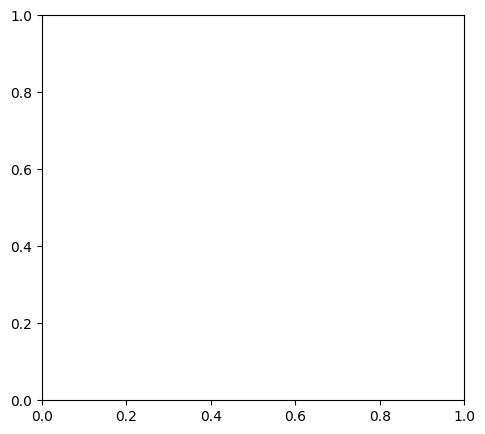

In [ ]:
import matplotlib.pyplot as plt
# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(agent.rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(agent.losses)
plt.title('Loss during Training')
plt.xlabel('Training Steps')
plt.ylabel('Loss')

plt.show()

In [ ]:
env = gym.make('ALE/Pong-v5')
#render_mode='rgb_array',
#frameskip=1,
#repeat_action_probability=0.0,
#full_action_space=False,
#max_episode_steps=1000
input_shape = (1, 84, 84)  # Example input shape (channels, height, width)
action_size = env.action_space.n
print(env.unwrapped.get_action_meanings())
print(action_size)
agent = DQNAgent(input_shape, action_size)
done = False
EPISODES = 1000
reward_history = []

for e in range(EPISODES):
    init_state = env.reset()
    total_reward = 0
    state = agent.preprocess_frame(env.reset()[0])
    state = np.stack([state] * 4, axis=0)  # Stack 4 frames
    #print(state.shape)
    for time in range(1000):
        #print(state.shape)
        action = agent.act(state)
        #step = env.step(action)
        #print(step)
        next_frame, reward, done, truncated, info = env.step(action)
        #print(next_frame.shape)
        next_frame = agent.preprocess_frame(next_frame)
        next_state = np.append(state[1:], [next_frame], axis=0)  # Append new frame to state
        #print(next_state.shape)
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        #print(next_state.shape)
        state = next_state
        #print(state.shape)
        if done:
            print(f"episode: {e}/{EPISODES}, score: {time}, e: {agent.epsilon:.2}, Reward: {total_reward}")
            wandb.log({"episode": e/EPISODES, "score": time, "e": round(agent.epsilon,2), "Total reward" : total_reward})
            reward_history.append(total_reward)
            break
    wandb.log({"episode": e/EPISODES, "score": time, "e": round(agent.epsilon,2), "Total reward" : total_reward})
    agent.replay()
    if e % 50 == 0:
        agent.save(f"dqn_model_{e}.pth")

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
6


<ipython-input-5-3a39b8440924>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame_tensor = torch.tensor(frame, dtype=torch.float32) / 255.0


episode: 0/1000, score: 763, e: 1.0, Reward: -21.0
episode: 1/1000, score: 823, e: 0.99, Reward: -21.0
episode: 2/1000, score: 791, e: 0.99, Reward: -21.0
episode: 3/1000, score: 791, e: 0.99, Reward: -21.0
episode: 4/1000, score: 901, e: 0.98, Reward: -20.0
episode: 5/1000, score: 888, e: 0.98, Reward: -20.0
episode: 7/1000, score: 967, e: 0.97, Reward: -20.0
episode: 8/1000, score: 946, e: 0.96, Reward: -21.0
episode: 9/1000, score: 810, e: 0.96, Reward: -21.0
episode: 11/1000, score: 823, e: 0.95, Reward: -21.0
episode: 12/1000, score: 763, e: 0.94, Reward: -21.0
episode: 13/1000, score: 941, e: 0.94, Reward: -21.0
episode: 14/1000, score: 947, e: 0.93, Reward: -20.0
episode: 18/1000, score: 956, e: 0.91, Reward: -20.0
episode: 19/1000, score: 841, e: 0.91, Reward: -20.0
episode: 20/1000, score: 930, e: 0.9, Reward: -20.0
episode: 21/1000, score: 950, e: 0.9, Reward: -20.0
episode: 23/1000, score: 962, e: 0.89, Reward: -20.0
episode: 24/1000, score: 913, e: 0.89, Reward: -21.0
episo

KeyboardInterrupt: 

In [ ]:
agent.save(f"dqn_model_final.pth")

In [ ]:
env = gym.make('ALE/Pong-v5',render_mode='rgb_array')
input_shape = (1, 84, 84)  # 4 frames, 84x84 each
action_size = env.action_space.n
agent = DQNAgent(input_shape, action_size)
agent.load('dqn_model_final.pth')  # Load the trained model

for episode in range(10):  # Play 10 episodes to test
    observation = env.reset()
    state = np.stack([agent.preprocess_frame(observation[0])] * 4, axis=0)  # Initialize state with 4 frames
    done = False
    total_reward = 0
    while not done:
        env.render()
        action = agent.act(state)
        next_observation, reward, done, info, _ = env.step(action)
        next_frame = agent.preprocess_frame(next_observation)
        state = np.append(state[1:], [next_frame], axis=0)  # Append new frame to state
        total_reward += reward
    print(f"Episode {episode + 1}: Total Reward: {total_reward}")

env.close()

<ipython-input-5-3a39b8440924>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame_tensor = torch.tensor(frame, dtype=torch.float32) / 255.0


Episode 1: Total Reward: -20.0
Episode 2: Total Reward: -20.0
Episode 3: Total Reward: -21.0
Episode 4: Total Reward: -20.0
Episode 5: Total Reward: -20.0
Episode 6: Total Reward: -21.0
Episode 7: Total Reward: -20.0
Episode 8: Total Reward: -21.0
Episode 9: Total Reward: -21.0
Episode 10: Total Reward: -20.0
